In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, misc
from sympy import symbols, diff, log, sqrt, lambdify

In [2]:
a = 1  # Distance between rods
b = 4  # Length of rods
n = 100  # Number of simulations
np.random.seed(1234)

# Generate random points along each rod
rod1_points = np.random.uniform(0, b, n)
rod2_points = np.random.uniform(0, b, n)

distances = np.sqrt(a**2 + (rod2_points - rod1_points)**2)

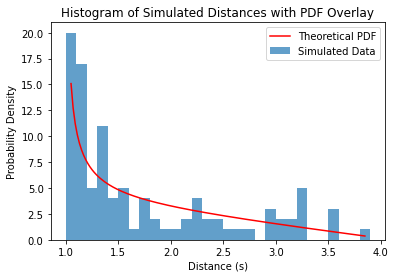

In [3]:
# Define histogram parameters
bin_width = 0.1
bins = np.arange(a, distances.max() + bin_width, bin_width)

def f_s(s, a, b):
    if s < a:
        return 0
    return (2 * s / b**2) * (b/np.sqrt(s**2 - a**2) - 1)

# Plot histogram
plt.hist(distances, bins=bins, density=False, alpha=0.7, label="Simulated Data")

# Generate theoretical PDF values
s_values = np.arange(a + bin_width / 2, distances.max(), bin_width / 5)
n = len(distances)
scaling_factor = n * bin_width
f_values = [f_s(s, a, b) * scaling_factor for s in s_values]

# Overlay theoretical PDF on histogram
plt.plot(s_values, f_values, color="red", label="Theoretical PDF")
plt.xlabel("Distance (s)")
plt.ylabel("Probability Density")
plt.legend()
plt.title("Histogram of Simulated Distances with PDF Overlay")
plt.show()

The histogram and theoretical PDF are well-aligned. This alignment confirms that the simulation accurately represents the theoretical distribution.

In [4]:
def negLogLikelihood(b_val):
    if b_val <= 0:
        return np.inf
    
    s_values = distances[distances > a] # Consider only valid distances
    pdf_values = (2 * s_values / b_val**2) * (np.sqrt(b_val**2 / (s_values**2 - a**2)) - 1)
    
    pdf_values = np.maximum(pdf_values, 1e-10) # Handle negative or zero PDF values
    
    return -np.sum(np.log(pdf_values))

print(negLogLikelihood(4))

64.64050690422843


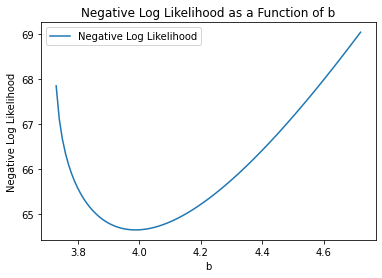

In [5]:
# Generate values for b and compute log-likelihood
s_max = np.max(distances)
b_min = np.sqrt(s_max**2 - a**2)
b_values = np.arange(b_min + bin_width / 10, b_min + 1, bin_width / 10)
neg_log_likelihoods = [negLogLikelihood(b) for b in b_values]

plt.plot(b_values, neg_log_likelihoods, label="Negative Log Likelihood")
plt.xlabel("b")
plt.ylabel("Negative Log Likelihood")
plt.title("Negative Log Likelihood as a Function of b")
plt.legend()
plt.show()

The curve of the negative log-likelihood shows a minimum near $b = 4$, consistent with expectations.

In [6]:
# Estimate b using optimization
b_min = np.sqrt(np.max(distances)**2 - a**2)
result = optimize.minimize_scalar(negLogLikelihood, bounds=(b_min, b_min + 5), method='bounded')
b_hat = result.x
print(f"Estimated b (b_hat): {b_hat:.6f}")

# Compute second derivative numerically
second_derivative = misc.derivative(negLogLikelihood, b_hat, dx=0.1, n=2)
sigma_b = 1 / np.sqrt(second_derivative)
print(f"Standard deviation of b (sigma_b): {sigma_b:.6f}")

Estimated b (b_hat): 3.987567
Standard deviation of b (sigma_b): 0.169934


In [7]:
b_val, s_val, a_val = symbols('b s a', positive=True)
pdf = (2 * s_val / b_val**2) * (sqrt(b_val**2 / (s_val**2 - a_val**2)) - 1)

# Computing the second derivative of the log-likelihood function with respect to  b
log_pdf = log(pdf)
first_derivative = diff(log_pdf, b_val)
second_derivative = diff(first_derivative, b_val)

# Convert to a numerical function
second_derivative_func = lambdify((b_val, s_val, a_val), second_derivative, "numpy")

# Computes the total second derivative by summing over all observed distances
def total_second_derivative(b_val, s_values, a_val):
    total = 0
    for s in s_values:
        total += second_derivative_func(b_val, s, a_val)
    return total

# Compute the standard deviation using fisher information
second_deriv_value = total_second_derivative(b_hat, distances, a)
new_sigma_b = 1 / np.sqrt(-second_deriv_value)
print(f"Standard deviation of b (sigma_b): {new_sigma_b:.6f}")

# Relative difference between the two methods
difference = np.abs(sigma_b-new_sigma_b)
rel_diff = difference/((sigma_b+new_sigma_b)/2)*100
print(f"Difference between sigma_b in Q5 and Q6: {difference:.6f}")
print(f"Relative difference between sigma_b in Q5 and Q6: {rel_diff:.6f}%")

Standard deviation of b (sigma_b): 0.173169
Difference between sigma_b in Q5 and Q6: 0.003235
Relative difference between sigma_b in Q5 and Q6: 1.885948%


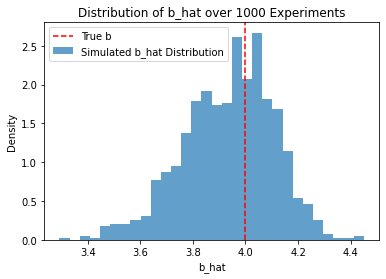

Mean of b_hat: 3.935612
Standard deviation of b_hat: 0.173181
Bias of b_hat: -0.064388


In [8]:
# Perform multiple experiments so we can analyze b_hat distribution
num_experiments = 1000
b_hats = []

for _ in range(num_experiments):
    rod1_points = np.random.uniform(0, b, n)
    rod2_points = np.random.uniform(0, b, n)
    distances = np.sqrt(a**2 + (rod2_points - rod1_points)**2)

    b_min = np.sqrt(np.max(distances)**2 - a**2)
    result = optimize.minimize_scalar(negLogLikelihood, bounds=(b_min, b_min + 5), method='bounded')
    b_hats.append(result.x)

plt.hist(b_hats, bins=30, density=True, alpha=0.7, label="Simulated b_hat Distribution")
plt.axvline(b, color="red", linestyle="dashed", label="True b")
plt.xlabel("b_hat")
plt.ylabel("Density")
plt.title("Distribution of b_hat over 1000 Experiments")
plt.legend()
plt.show()

mean_b_hat = np.mean(b_hats)
std_b_hat = np.std(b_hats)
bias = mean_b_hat - b
print(f"Mean of b_hat: {mean_b_hat:.6f}")
print(f"Standard deviation of b_hat: {std_b_hat:.6f}")
print(f"Bias of b_hat: {bias:.6f}")